# Package Import + Model Definition + Data Generation

In [1]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize
import time
import pickle
import uuid

# Constants
M_REPLICATES = 10
LAYER_UNITS = [50, 25]
N_ENSEMBLE = 10
SIGMA = 0.25

def build_model(layer_units, dropout_rate):
    """Construct neural network with named layers for clarity"""
    tf.keras.backend.clear_session()

    model = Sequential(name="Sequential_Model")

    # Input layer with explicit name
    model.add(Input(shape=(5,), name="Input_Layer"))

    # Hidden layers with numbered names
    for i, units in enumerate(layer_units, start=1):
        model.add(
            Dense(units, activation='tanh', name=f"Hidden_Tanh_{i}")
        )

    # Dropout layer with descriptive name
    model.add(
        Dropout(dropout_rate, name=f"Dropout_{dropout_rate:.2f}")
    )

    # Output layer
    model.add(Dense(1, name="Output_Layer"))

    model.compile(optimizer='adam', loss='mse')

    # Verify names (optional debug print)
    print("Layer names:", [layer.name for layer in model.layers])

    return model

def generate_data(random_seed, SIGMA = 0.25):
    """Generate synthetic dataset with proper seeding"""
    np.random.seed(random_seed)
    n_samples = 2000
    X = np.random.uniform(0, 10, size=(n_samples, 1))
    noise = np.random.normal(0, SIGMA, n_samples)
    y = np.sin(X[:, 0]) + noise
    X_poly = np.hstack([X, X**2, X**3, X**4, X**5])
    X_poly = (X_poly - np.mean(X_poly, axis = 0)) / np.std(X_poly, axis=0)
    return X_poly, y

# Helper Functions

In [2]:
def mc_dropout_predictions(model, X, n_samples=100):
    preds = np.array([model(X, training=True).numpy().squeeze() for _ in range(n_samples)])
    return preds.mean(0), preds.std(0)

# Ensemble Functions

In [3]:
def run_ensemble(model, X_train, y_train, X_test, X_val, ensemble_type, n_ensemble=10, verb=1):
        preds, val_preds, train_times, infer_times = [], [], [], []

        for _ in range(n_ensemble):
            # Training setup
            start_train = time.time()
            if ensemble_type == 'bootstrap':
                idx = np.random.choice(len(X_train), len(X_train), replace=True)
                model.fit(X_train[idx], y_train[idx], epochs=100, verbose=verb)
            elif ensemble_type == 'bayesian':
                weights = np.random.dirichlet(np.ones(len(X_train)))
                model.fit(X_train, y_train, sample_weight=weights, epochs=100, verbose=verb)
            elif ensemble_type == 'parametric':
                y_synth = model.predict(X_train) + np.random.normal(0, np.std(y_train - model.predict(X_train)), y_train.shape)
                model.fit(X_train, y_synth, epochs=100, verbose=verb)

            train_times.append(time.time() - start_train)

            # Inference
            start_infer = time.time()
            preds.append(model.predict(X_test).squeeze())
            val_preds.append(model.predict(X_val).squeeze())
            infer_times.append(time.time() - start_infer)

        return np.array(preds), np.array(val_preds), train_times, infer_times

In [4]:
def plot_results(x, y_true, pred_mean, pred_std, title, filename):
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y_true, label='Simulated Data', color='black', alpha=0.6, s=10)
    plt.plot(x, pred_mean, label='Prediction Mean', linewidth=2)
    plt.fill_between(x, pred_mean - pred_std, pred_mean + pred_std, alpha=0.3, label='Uncertainty')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.savefig(filename)
    plt.close()

def plot_combined_comparison(X_test, y_test, mc_mean, mc_std, results, filename):
    plt.figure(figsize=(12, 8))
    sort_idx = X_test[:, 0].argsort()
    X_sorted = X_test[sort_idx, 0].squeeze()
    y_sorted = y_test[sort_idx]

    # Plot ground truth
    plt.scatter(X_sorted, y_sorted, label='Observed Data',
                color='black', alpha=0.4, s=15, zorder=5)

    # Plot MC Dropout
    plt.plot(X_sorted, mc_mean[sort_idx], label='MC Dropout',
             color='#1f77b4', linewidth=2.5)
    plt.fill_between(X_sorted,
                     mc_mean[sort_idx] - mc_std[sort_idx],
                     mc_mean[sort_idx] + mc_std[sort_idx],
                     color='#1f77b4', alpha=0.15)

    # Plot ensembles
    colors = ['#ff7f0e', '#2ca02c', '#d62728']
    styles = ['--', '-.', ':']
    for (method, data), color, style in zip(results.items(), colors, styles):
        label = method.title().replace('_', ' ') + ' Ensemble'
        plt.plot(X_sorted, data['mean'][sort_idx], label=label,
                 linestyle=style, linewidth=2, color=color)
        plt.fill_between(X_sorted,
                         data['mean'][sort_idx] - data['std'][sort_idx],
                         data['mean'][sort_idx] + data['std'][sort_idx],
                         color=color, alpha=0.15)

    plt.xlabel('Input Feature (X)', fontsize=12)
    plt.ylabel('Target Value (Y)', fontsize=12)
    plt.title('Combined Uncertainty Quantification Comparison', fontsize=14)
    plt.legend(fontsize=10, loc='upper right')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()


# Result Processing

In [5]:
def bars_with_bands(grand_mean, grand_meansd, sd_of_sd, sort_idx, X_test, filename='test', title='hi mom', direc = "."):
    os.makedirs(direc, exist_ok=True)  # Ensure directory exists
    os.chdir(direc)  # Use the provided `direc` argument
    step = 20
    selected_x = X_test[sort_idx][::step]
    y_mean = grand_mean[sort_idx] + 1.96 * grand_meansd[sort_idx]
    selected_y = y_mean[::step]
    selected_std = 1.96 * sd_of_sd[::step]

    plt.figure(figsize=(12, 5))
    plt.plot( X_test[sort_idx], grand_mean[sort_idx])
    plt.plot( X_test[sort_idx],
                grand_mean[sort_idx] - 1.96 * grand_meansd[sort_idx],
                alpha = 0.25, ls='--')
    plt.plot( X_test[sort_idx],
                grand_mean[sort_idx] + 1.96 * grand_meansd[sort_idx],
                alpha = 0.25, ls='--')
    plt.errorbar(
        selected_x,
        selected_y,
        yerr= selected_std,
        fmt='s',          # Square markers
        color='green',
        ecolor='orange',
        capsize=5,
        label='Error Bars (Every 20th point)'
    )
    plt.title(title)
    plt.savefig(filename + '.png')
    plt.close()

# Body

In [6]:
def main(LAYER_UNITS = [50, 25], DROPOUT_RATE = 0.1, N_ENSEMBLE = 5,
         N_MCD = 100, SIGMA = 0.25):
    X2, y = generate_data(42, SIGMA = SIGMA)
    X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

    base_model = build_model(LAYER_UNITS, DROPOUT_RATE)
    base_model.fit(X_train, y_train, epochs=100, batch_size=32,
                      verbose=0, validation_data=(X_val, y_val))

    # MC Dropout
    start_time = time.time()
    mc_preds = mc_dropout_predictions(base_model, X_test)
    mc_total_infer_time = time.time() - start_time
    mc_mean = mc_preds[0]
    mc_std = mc_preds[1]
    # Bootstrap Ensemble

    ensembles = {
        'bootstrap': run_ensemble(base_model, X_train, y_train, X_test, X_val, 'bootstrap', n_ensemble=N_ENSEMBLE, verb=0),
        'bayesian': run_ensemble(base_model, X_train, y_train, X_test, X_val, 'bayesian', n_ensemble=N_ENSEMBLE, verb=0),
        'parametric': run_ensemble(base_model, X_train, y_train, X_test, X_val, 'parametric', n_ensemble=N_ENSEMBLE, verb=0)
    }


    # Process results
    results = {}
    for name, (preds, val_preds, train_t, infer_t) in ensembles.items():
        # Calculate metrics
        val_mean = val_preds.mean(0)
        val_std_uc = val_preds.std(0)
        val_std_uc[val_std_uc == 0] = 1e-10  # or some other small value
        residuals = y_val - val_mean

        # Calibration optimization
        def loss(params):
            a, b = params
            sigma_cal = a * val_std_uc + b
            sigma_cal = np.clip(sigma_cal, 1e-6, None)
            return np.sum(0.5 * (residuals**2 / sigma_cal**2) + np.log(sigma_cal))

        opt = minimize(loss, [1, 0], method='Nelder-Mead')
        a, b = opt.x

        # Calculate calibrated uncertainties
        val_std_cal = a * val_std_uc + b
        test_std_uc = preds.std(0)
        test_std_cal = a * test_std_uc + b

        # Generate calibration plots
        plt.figure(figsize=(12, 5))

        # Uncalibrated Q-Q plot
        plt.subplot(121)
        stats.probplot(residuals/val_std_uc, dist="norm", plot=plt)
        plt.title(f'{name.title()} Uncalibrated Residuals')

        # Calibrated Q-Q plot
        plt.subplot(122)
        stats.probplot(residuals/val_std_cal, dist="norm", plot=plt)
        plt.title(f'{name.title()} Calibrated Residuals')

        plt.tight_layout()
        plt.savefig(f'{name}_calibration.png')
        plt.close()

        # Store results
        results[name] = {
                'mean': preds.mean(0),
                'std': test_std_cal,
                'metrics': {
                    'MSE': mean_squared_error(y_test, preds.mean(0)),
                    'MAE': mean_absolute_error(y_test, preds.mean(0)),
                    'Avg Uncertainty': test_std_cal.mean()
                },
                'times': {
                    'train': np.mean(train_t),
                    'infer': np.sum(infer_t)
                }
            }
        # Save prediction plots
        # sort_idx = X_test[:, 0].argsort()
        # plot_results(X_test[sort_idx, 0], y_test[sort_idx],
        #             preds.mean(0)[sort_idx], test_std_cal[sort_idx],
        #             f'{name.title()} Ensemble Predictions',
        #             f'{name}_ensemble.png')

        # Generate combined comparison plot
        # plot_combined_comparison(
        #    X_test, y_test,
        #    mc_mean, mc_std,
        #    results,
        #    f'combined_methods_comparison.png'
        # )

    # Save metrics
    metrics_df = pd.DataFrame({k: v['metrics'] for k, v in results.items()}).T
    # metrics_df.to_csv('metrics_comparison.csv')

    comp_data = {
    "MC Dropout": {
        "Avg Training Time (s)": None,
        "Total Inference Time (s)": round(mc_total_infer_time, 4),
        "Avg Inference Time (s)": round(mc_total_infer_time/100, 6)
        }
    }

    for name, data in results.items():
        comp_data[name.title() + " Ensemble"] = {
              "Avg Training Time (s)": round(data['times']['train'], 4),
              "Total Inference Time (s)": round(data['times']['infer'], 4),
              "Avg Inference Time (s)": round(np.mean(data['times']['infer']/N_ENSEMBLE), 6)
          }

        comp_df = pd.DataFrame(comp_data).T
        comp_df = comp_df[[
          "Avg Training Time (s)",
          "Total Inference Time (s)",
          "Avg Inference Time (s)"
        ]]
    # comp_df.to_csv('computational_metrics.csv')

    ret = dict()
    ret['mc_dropout_mean'] = mc_mean
    ret['mc_dropout_sd']   = mc_std
    ret['mc_total_infer_time'] = mc_total_infer_time
    ret['ensembles']       = ensembles
    ret['metrics_df']      = metrics_df
    ret['comp_df']         = comp_df
    ret['calibration_results'] = results
    ret['dataset'] = [X_train, y_train, X_test, y_test, X_val, y_val]


    # Generate a random filename (e.g., "4a3b2c1d.pkl")
    filename = f"{uuid.uuid4().hex}.pkl"

    # Save the dictionary
    with open(filename, "wb") as f:
        pickle.dump(ret, f)

    return ret

In [7]:
def doVis(ret,SIGMA=0.25):
    res = ret
    sort_idx = res[0]['dataset'][2][:,0].argsort()
    mc_dropout_grand_mean = np.mean([res[k]['mc_dropout_mean'] for k in range(len(res))], axis = 0)
    mc_dropout_grand_meansd = np.mean([res[k]['mc_dropout_sd'] for k in range(len(res))], axis = 0)
    mc_dropout_sd_of_sd = np.std([res[k]['mc_dropout_sd'] for k in range(len(res))], axis = 0)
    #   M   ensembles    method  test_pred
    # mean curve
    # sd for bands
    # sd for bars on the bands
    print("Hey :p")
    bootstrap_grand_mean = np.mean([res[k]['calibration_results']['bootstrap']['mean'] for k in range(len(res))], axis = 0)
    bootstrap_grand_meansd = np.mean([res[k]['calibration_results']['bootstrap']['std'] for k in range(len(res))], axis = 0) # preds (test_preds), val_preds, train_time, inf_time
    bootstrap_sd_of_sd = np.std([res[k]['calibration_results']['bootstrap']['std'] for k in range(len(res))], axis = 0) # preds (test_preds), val_preds, train_time, inf_time
    bayesian_grand_mean = np.mean([res[k]['calibration_results']['bayesian']['mean'] for k in range(len(res))], axis=0)
    bayesian_grand_meansd = np.mean([res[k]['calibration_results']['bayesian']['std'] for k in range(len(res))], axis=0)  # preds (test_preds), val_preds, train_time, inf_time
    bayesian_sd_of_sd = np.std([res[k]['calibration_results']['bayesian']['std'] for k in range(len(res))], axis=0)  # preds (test_preds), val_preds, train_time, inf_time
    parametric_grand_mean = np.mean([res[k]['calibration_results']['parametric']['mean'] for k in range(len(res))], axis=0)
    parametric_grand_meansd = np.mean([res[k]['calibration_results']['parametric']['std'] for k in range(len(res))], axis=0)  # preds (test_preds), val_preds, train_time, inf_time
    parametric_sd_of_sd = np.std([res[k]['calibration_results']['parametric']['std'] for k in range(len(res))], axis=0)  # preds (test_preds), val_preds, train_time, inf_time

    bars_with_bands(mc_dropout_grand_mean, mc_dropout_grand_meansd, mc_dropout_sd_of_sd, sort_idx, res[0]['dataset'][2][:,0],
               filename = 'MCD_DR_' + str(SIGMA) + '_BWB',
               title = "MC Dropout Simulation Results (M = 10 MC Replicates)")
    bars_with_bands(bootstrap_grand_mean, bootstrap_grand_meansd, bootstrap_sd_of_sd, sort_idx, res[0]['dataset'][2][:,0],
                   filename = 'BOOT_DR_' + str(SIGMA) + '_BWB',
                   title = "Bootstrap BE Simulation Results (M = 10 MC Replicates)")
    bars_with_bands(bayesian_grand_mean, bayesian_grand_meansd, bayesian_sd_of_sd, sort_idx, res[0]['dataset'][2][:,0],
                   filename = 'BAYES_DR_' + str(SIGMA) + '_BWB',
                   title = "Bayesian BE Simulation Results (M = 10 MC Replicates)")
    bars_with_bands(parametric_grand_mean, parametric_grand_meansd, parametric_sd_of_sd, sort_idx, res[0]['dataset'][2][:,0],
                   filename = 'PARAM_DR_' + str(SIGMA) + '_BWB',
                   title = "Parametric BE Simulation Results (M = 10 MC Replicates)")

    error_df = pd.concat([res[k]['metrics_df'] for k in range(len(res))]).groupby(level=0).mean()
    comp_df = pd.concat([res[k]['comp_df'] for k in range(len(res))]).groupby(level=0).mean()

    error_df.to_csv('metrics_comparison_DR' + str(SIGMA) + '.csv')
    comp_df.to_csv('computational_comparison_DR' + str(SIGMA) + '.csv')


In [8]:
from concurrent.futures import ProcessPoolExecutor

In [9]:
import concurrent.futures
import time
import logging

# Configure logging to show thread/process info
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(threadName)s] - %(message)s'
)

def main2(task_id, SIGMA):
    """Example task that simulates work"""
    logging.info(f"Task {task_id} started")
    logging.info(f"CWD: {os.getcwd()}")
    result = main(SIGMA=SIGMA)
    logging.info("Did the visualization")
    return result

def wrapper2(SIGMA = 0.25, M=10):
    """Parallel executor with progress tracking"""
    results = []
    start_time = time.time()

    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        # Submit tasks
        futures = {executor.submit(main2, i, SIGMA): i for i in range(M)}

        # Track progress as tasks complete
        for future in concurrent.futures.as_completed(futures):
            task_id = futures[future]
            try:
                logging.info(f"✅ Task {task_id} result collected")
            except Exception as e:
                logging.error(f"❌ Task {task_id} failed: {e}")
    logging.info(f"All tasks done in {time.time() - start_time:.2f}s")
    return results

In [10]:
def run_sim():
    SIGMAS = [0.25, 0.5, 1, 2]
    for sig in SIGMAS:
        BASE_DIR = "sim_results_" + str(sig)
        os.makedirs(os.path.abspath(BASE_DIR), exist_ok=True)
        os.chdir(BASE_DIR)
        wrapper2(SIGMA = sig)
        os.chdir('..')

2025-04-22 22:38:49,541 [ThreadPoolExecutor-0_0] - Task 0 started
2025-04-22 22:38:49,541 [ThreadPoolExecutor-0_1] - Task 1 started
2025-04-22 22:38:49,541 [ThreadPoolExecutor-0_0] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_0.25
2025-04-22 22:38:49,541 [ThreadPoolExecutor-0_2] - Task 2 started
2025-04-22 22:38:49,541 [ThreadPoolExecutor-0_1] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_0.25
2025-04-22 22:38:49,551 [ThreadPoolExecutor-0_3] - Task 3 started
2025-04-22 22:38:49,556 [ThreadPoolExecutor-0_2] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_0.25
2025-04-22 22:38:49,561 [ThreadPoolExecutor-0_3] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_0.25


Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
38/38 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 3ms/step


2025-04-22 22:43:19,371 [ThreadPoolExecutor-0_0] - Task 4 started
2025-04-22 22:43:19,371 [MainThread] - ✅ Task 0 result collected
2025-04-22 22:43:19,372 [ThreadPoolExecutor-0_0] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_0.25


Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']


2025-04-22 22:43:21,126 [ThreadPoolExecutor-0_3] - Task 5 started
2025-04-22 22:43:21,126 [MainThread] - ✅ Task 3 result collected
2025-04-22 22:43:21,129 [ThreadPoolExecutor-0_3] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_0.25
2025-04-22 22:43:21,470 [ThreadPoolExecutor-0_1] - Did the visualization
2025-04-22 22:43:21,475 [ThreadPoolExecutor-0_1] - Task 6 started
2025-04-22 22:43:21,482 [MainThread] - ✅ Task 1 result collected
2025-04-22 22:43:21,502 [ThreadPoolExecutor-0_1] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_0.25


Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']


2025-04-22 22:43:21,751 [ThreadPoolExecutor-0_2] - Did the visualization
2025-04-22 22:43:21,755 [ThreadPoolExecutor-0_2] - Task 7 started
2025-04-22 22:43:21,757 [MainThread] - ✅ Task 2 result collected
2025-04-22 22:43:21,762 [ThreadPoolExecutor-0_2] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_0.25


Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
38/38 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 4ms/step


2025-04-22 22:48:51,361 [ThreadPoolExecutor-0_0] - Did the visualization
2025-04-22 22:48:51,367 [ThreadPoolExecutor-0_0] - Task 8 started
2025-04-22 22:48:51,368 [MainThread] - ✅ Task 4 result collected
2025-04-22 22:48:51,371 [ThreadPoolExecutor-0_0] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_0.25


Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']


2025-04-22 22:48:53,453 [ThreadPoolExecutor-0_1] - Did the visualization
2025-04-22 22:48:53,456 [ThreadPoolExecutor-0_1] - Task 9 started
2025-04-22 22:48:53,457 [MainThread] - ✅ Task 6 result collected
2025-04-22 22:48:53,462 [ThreadPoolExecutor-0_1] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_0.25


Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
13/13 [==============================] - 0s 3ms/step


2025-04-22 22:48:58,920 [ThreadPoolExecutor-0_3] - Did the visualization
2025-04-22 22:48:58,922 [MainThread] - ✅ Task 5 result collected


13/13 [==============================] - 0s 2ms/step


2025-04-22 22:49:03,195 [ThreadPoolExecutor-0_2] - Did the visualization
2025-04-22 22:49:03,200 [MainThread] - ✅ Task 7 result collected


13/13 [==============================] - 0s 545us/step


2025-04-22 22:51:06,236 [ThreadPoolExecutor-0_0] - Did the visualization
2025-04-22 22:51:06,244 [MainThread] - ✅ Task 8 result collected


13/13 [==============================] - 0s 0s/step


2025-04-22 22:51:07,596 [ThreadPoolExecutor-0_1] - Did the visualization
2025-04-22 22:51:07,597 [MainThread] - ✅ Task 9 result collected
2025-04-22 22:51:07,601 [MainThread] - All tasks done in 738.06s
2025-04-22 22:51:07,610 [ThreadPoolExecutor-1_0] - Task 0 started
2025-04-22 22:51:07,612 [ThreadPoolExecutor-1_1] - Task 1 started
2025-04-22 22:51:07,614 [ThreadPoolExecutor-1_2] - Task 2 started
2025-04-22 22:51:07,615 [ThreadPoolExecutor-1_0] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_0.5
2025-04-22 22:51:07,616 [ThreadPoolExecutor-1_3] - Task 3 started
2025-04-22 22:51:07,616 [ThreadPoolExecutor-1_1] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_0.5
2025-04-22 22:51:07,619 [ThreadPoolExecutor-1_2] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_0.5
2025-04-22 22:51:07,622 [ThreadPoolExecutor-1_3] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_0.5


Layer names:Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
 ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
38/38 [==============================] - 0s 10ms/step


13/13 [==============================] - 0s 3ms/step


2025-04-22 22:56:25,958 [ThreadPoolExecutor-1_1] - Did the visualization
2025-04-22 22:56:25,958 [ThreadPoolExecutor-1_1] - Task 4 started
2025-04-22 22:56:25,966 [MainThread] - ✅ Task 1 result collected
2025-04-22 22:56:25,970 [ThreadPoolExecutor-1_1] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_0.5
2025-04-22 22:56:27,702 [ThreadPoolExecutor-1_0] - Did the visualization
2025-04-22 22:56:27,743 [ThreadPoolExecutor-1_0] - Task 5 started
2025-04-22 22:56:27,867 [ThreadPoolExecutor-1_0] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_0.5
2025-04-22 22:56:27,840 [MainThread] - ✅ Task 0 result collected
2025-04-22 22:56:27,760 [ThreadPoolExecutor-1_3] - Did the visualization
2025-04-22 22:56:27,932 [ThreadPoolExecutor-1_3] - Task 6 started
2025-04-22 22:56:27,942 [ThreadPoolExecutor-1_3] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_0.5
2025-04-22 22:56:27,942 [MainThread] - ✅ Task 3 result collected


Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
Layer names:Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
 ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']


2025-04-22 22:56:29,489 [ThreadPoolExecutor-1_2] - Did the visualization
2025-04-22 22:56:29,499 [ThreadPoolExecutor-1_2] - Task 7 started
2025-04-22 22:56:29,510 [MainThread] - ✅ Task 2 result collected
2025-04-22 22:56:29,535 [ThreadPoolExecutor-1_2] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_0.5


Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 2ms/step


2025-04-22 23:01:51,229 [ThreadPoolExecutor-1_3] - Did the visualization
2025-04-22 23:01:51,232 [ThreadPoolExecutor-1_3] - Task 8 started
2025-04-22 23:01:51,232 [MainThread] - ✅ Task 6 result collected
2025-04-22 23:01:51,233 [ThreadPoolExecutor-1_3] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_0.5
2025-04-22 23:01:51,238 [ThreadPoolExecutor-1_0] - Did the visualization
2025-04-22 23:01:51,240 [ThreadPoolExecutor-1_0] - Task 9 started
2025-04-22 23:01:51,240 [MainThread] - ✅ Task 5 result collected
2025-04-22 23:01:51,241 [ThreadPoolExecutor-1_0] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_0.5


Layer names:Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
 ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']


2025-04-22 23:01:53,757 [ThreadPoolExecutor-1_1] - Did the visualization
2025-04-22 23:01:53,760 [MainThread] - ✅ Task 4 result collected
2025-04-22 23:01:53,765 [ThreadPoolExecutor-1_2] - Did the visualization
2025-04-22 23:01:53,767 [MainThread] - ✅ Task 7 result collected


13/13 [==============================] - 0s 7ms/step


2025-04-22 23:05:06,320 [ThreadPoolExecutor-1_0] - Did the visualization
2025-04-22 23:05:06,321 [MainThread] - ✅ Task 9 result collected
2025-04-22 23:05:06,322 [ThreadPoolExecutor-1_3] - Did the visualization
2025-04-22 23:05:06,324 [MainThread] - ✅ Task 8 result collected
2025-04-22 23:05:06,328 [MainThread] - All tasks done in 838.72s
2025-04-22 23:05:06,344 [ThreadPoolExecutor-2_0] - Task 0 started
2025-04-22 23:05:06,347 [ThreadPoolExecutor-2_1] - Task 1 started
2025-04-22 23:05:06,347 [ThreadPoolExecutor-2_0] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_1
2025-04-22 23:05:06,347 [ThreadPoolExecutor-2_2] - Task 2 started
2025-04-22 23:05:06,347 [ThreadPoolExecutor-2_3] - Task 3 started
2025-04-22 23:05:06,347 [ThreadPoolExecutor-2_1] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_1
2025-04-22 23:05:06,353 [ThreadPoolExecutor-2_2] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_1
2025-04-22 23:05:06,359 [ThreadPoolExecutor-

Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']Layer names:
 ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
38/38 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 11ms/step


2025-04-22 23:09:34,533 [ThreadPoolExecutor-2_0] - Did the visualization
2025-04-22 23:09:34,533 [ThreadPoolExecutor-2_0] - Task 4 started
2025-04-22 23:09:34,533 [ThreadPoolExecutor-2_0] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_1
2025-04-22 23:09:34,533 [MainThread] - ✅ Task 0 result collected


Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']


2025-04-22 23:09:35,045 [ThreadPoolExecutor-2_2] - Did the visualization
2025-04-22 23:09:35,061 [ThreadPoolExecutor-2_2] - Task 5 started
2025-04-22 23:09:35,061 [MainThread] - ✅ Task 2 result collected
2025-04-22 23:09:35,077 [ThreadPoolExecutor-2_2] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_1


Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']


2025-04-22 23:09:36,667 [ThreadPoolExecutor-2_1] - Did the visualization
2025-04-22 23:09:36,676 [ThreadPoolExecutor-2_1] - Task 6 started
2025-04-22 23:09:36,677 [MainThread] - ✅ Task 1 result collected
2025-04-22 23:09:36,679 [ThreadPoolExecutor-2_1] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_1


Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
13/13 [==============================] - 0s 5ms/step


2025-04-22 23:09:41,481 [ThreadPoolExecutor-2_3] - Did the visualization
2025-04-22 23:09:41,487 [ThreadPoolExecutor-2_3] - Task 7 started
2025-04-22 23:09:41,488 [MainThread] - ✅ Task 3 result collected
2025-04-22 23:09:41,490 [ThreadPoolExecutor-2_3] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_1


Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 7ms/step


2025-04-22 23:14:51,888 [ThreadPoolExecutor-2_2] - Did the visualization
2025-04-22 23:14:51,890 [ThreadPoolExecutor-2_2] - Task 8 started
2025-04-22 23:14:51,891 [MainThread] - ✅ Task 5 result collected
2025-04-22 23:14:51,893 [ThreadPoolExecutor-2_2] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_1


Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']


2025-04-22 23:14:52,802 [ThreadPoolExecutor-2_1] - Did the visualization
2025-04-22 23:14:52,806 [ThreadPoolExecutor-2_1] - Task 9 started
2025-04-22 23:14:52,806 [MainThread] - ✅ Task 6 result collected
2025-04-22 23:14:52,810 [ThreadPoolExecutor-2_1] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_1


Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']


2025-04-22 23:14:55,738 [ThreadPoolExecutor-2_0] - Did the visualization
2025-04-22 23:14:55,747 [MainThread] - ✅ Task 4 result collected


13/13 [==============================] - 0s 3ms/step


2025-04-22 23:15:00,231 [ThreadPoolExecutor-2_3] - Did the visualization
2025-04-22 23:15:00,233 [MainThread] - ✅ Task 7 result collected


13/13 [==============================] - 0s 1ms/step


2025-04-22 23:17:17,322 [ThreadPoolExecutor-2_2] - Did the visualization
2025-04-22 23:17:17,322 [MainThread] - ✅ Task 8 result collected
2025-04-22 23:17:17,933 [ThreadPoolExecutor-2_1] - Did the visualization
2025-04-22 23:17:17,934 [MainThread] - ✅ Task 9 result collected
2025-04-22 23:17:17,939 [MainThread] - All tasks done in 731.60s
2025-04-22 23:17:17,953 [ThreadPoolExecutor-3_0] - Task 0 started
2025-04-22 23:17:17,956 [ThreadPoolExecutor-3_1] - Task 1 started
2025-04-22 23:17:17,957 [ThreadPoolExecutor-3_0] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_2
2025-04-22 23:17:17,960 [ThreadPoolExecutor-3_2] - Task 2 started
2025-04-22 23:17:17,961 [ThreadPoolExecutor-3_3] - Task 3 started
2025-04-22 23:17:17,962 [ThreadPoolExecutor-3_1] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_2
2025-04-22 23:17:17,969 [ThreadPoolExecutor-3_2] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_2
2025-04-22 23:17:17,974 [ThreadPoolExecutor-

Layer names:Layer names:Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
 ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
 ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 2ms/step


2025-04-22 23:23:29,935 [ThreadPoolExecutor-3_0] - Did the visualization
2025-04-22 23:23:29,937 [ThreadPoolExecutor-3_0] - Task 4 started
2025-04-22 23:23:29,937 [MainThread] - ✅ Task 0 result collected
2025-04-22 23:23:29,938 [ThreadPoolExecutor-3_0] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_2


Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']


2025-04-22 23:23:30,758 [ThreadPoolExecutor-3_2] - Did the visualization
2025-04-22 23:23:30,764 [ThreadPoolExecutor-3_2] - Task 5 started
2025-04-22 23:23:30,764 [MainThread] - ✅ Task 2 result collected
2025-04-22 23:23:30,770 [ThreadPoolExecutor-3_2] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_2


Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']


2025-04-22 23:23:32,745 [ThreadPoolExecutor-3_1] - Did the visualization
2025-04-22 23:23:32,745 [ThreadPoolExecutor-3_1] - Task 6 started
2025-04-22 23:23:32,745 [MainThread] - ✅ Task 1 result collected
2025-04-22 23:23:32,745 [ThreadPoolExecutor-3_1] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_2
2025-04-22 23:23:33,180 [ThreadPoolExecutor-3_3] - Did the visualization


Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']


2025-04-22 23:23:33,180 [ThreadPoolExecutor-3_3] - Task 7 started
2025-04-22 23:23:33,188 [MainThread] - ✅ Task 3 result collected
2025-04-22 23:23:33,190 [ThreadPoolExecutor-3_3] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_2


Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']
38/38 [==============================] - 1s 13ms/step


13/13 [==============================] - 0s 5ms/step


2025-04-22 23:29:15,067 [ThreadPoolExecutor-3_0] - Did the visualization
2025-04-22 23:29:15,067 [ThreadPoolExecutor-3_0] - Task 8 started
2025-04-22 23:29:15,067 [MainThread] - ✅ Task 4 result collected
2025-04-22 23:29:15,067 [ThreadPoolExecutor-3_0] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_2


13/13 [==============================] - 0s 6ms/step


2025-04-22 23:29:18,927 [ThreadPoolExecutor-3_2] - Did the visualization
2025-04-22 23:29:18,935 [ThreadPoolExecutor-3_2] - Task 9 started
2025-04-22 23:29:18,946 [ThreadPoolExecutor-3_2] - CWD: I:\My Drive\Classes\Spring25\758\FInal Project\sim_results_2
2025-04-22 23:29:18,936 [MainThread] - ✅ Task 5 result collected


Layer names: ['Hidden_Tanh_1', 'Hidden_Tanh_2', 'Dropout_0.10', 'Output_Layer']


2025-04-22 23:29:19,741 [ThreadPoolExecutor-3_1] - Did the visualization
2025-04-22 23:29:19,750 [MainThread] - ✅ Task 6 result collected
2025-04-22 23:29:23,963 [ThreadPoolExecutor-3_3] - Did the visualization
2025-04-22 23:29:23,965 [MainThread] - ✅ Task 7 result collected


13/13 [==============================] - 0s 2ms/step


2025-04-22 23:31:53,565 [ThreadPoolExecutor-3_0] - Did the visualization
2025-04-22 23:31:53,565 [MainThread] - ✅ Task 8 result collected


13/13 [==============================] - 0s 2ms/step


2025-04-22 23:31:54,780 [ThreadPoolExecutor-3_2] - Did the visualization
2025-04-22 23:31:54,780 [MainThread] - ✅ Task 9 result collected
2025-04-22 23:31:54,780 [MainThread] - All tasks done in 876.83s


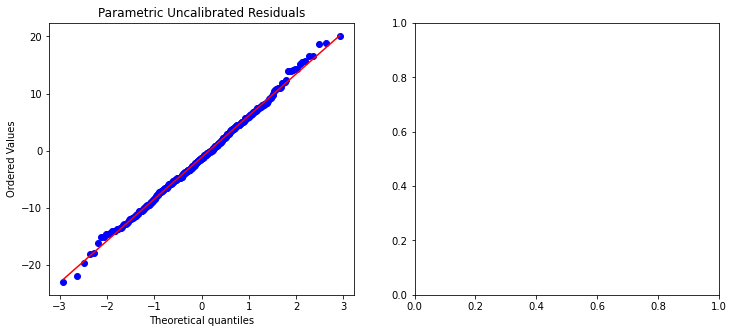

In [11]:
run_sim()

In [13]:
from pathlib import Path
import pickle
import glob

# Get all .pkl files in current directory
pkl_files = glob.glob("./sim_results_0.25/*.pkl")

# Load all files into a list
loaded_data = []
for file in pkl_files:
    with open(file, "rb") as f:
        loaded_data.append(pickle.load(f))

os.chdir("./sim_results_0.25/")
doVis(loaded_data, SIGMA=0.25)
os.chdir("..")

pkl_files = glob.glob("./sim_results_0.5/*.pkl")

# Load all files into a list
loaded_data = []
for file in pkl_files:
    with open(file, "rb") as f:
        loaded_data.append(pickle.load(f))

os.chdir("./sim_results_0.5/")
doVis(loaded_data, SIGMA=0.5)
os.chdir("..")

pkl_files = glob.glob("./sim_results_1/*.pkl")

# Load all files into a list
loaded_data = []
for file in pkl_files:
    with open(file, "rb") as f:
        loaded_data.append(pickle.load(f))

os.chdir("./sim_results_1/")
doVis(loaded_data, SIGMA=1)
os.chdir("..")

pkl_files = glob.glob("./sim_results_2/*.pkl")

# Load all files into a list
loaded_data = []
for file in pkl_files:
    with open(file, "rb") as f:
        loaded_data.append(pickle.load(f))

os.chdir("./sim_results_2/")
doVis(loaded_data, SIGMA=2)
os.chdir("..")

Hey :p
Hey :p
Hey :p
Hey :p
